In [1]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.performance as sfp
from tqdm import tqdm
import datetime as dt

/home/kylecm11/silver_fund/orthogonal-alphas/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-02 19:57:32,000	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
alpha_data = pl.read_parquet("../signal_weights/signal_data.parquet").with_columns(pl.col('return').shift(-1).over('barrid').alias('fwd_return'))

alpha_data

date,barrid,ticker,price,return,specific_return,specific_risk,historical_beta,predicted_beta,market_cap,daily_volume,bid_ask_spread,log_return,momentum,meanrev,bab,momentum_z,meanrev_z,bab_z,momentum_alpha,meanrev_alpha,bab_alpha,fwd_return
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.001595,-0.00788,0.550569,0.328385,0.34349,6.006157e8,121693.0,0.01,-0.001596,null,null,-0.34349,null,null,2.149267,null,null,0.059166,0.009585
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.009585,0.00365,0.55028,0.334989,0.353329,6.0865392e8,131728.0,0.01,0.009539,null,null,-0.353329,null,null,2.111728,null,null,0.058102,-0.001582
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.001582,-0.00731,0.548074,0.330713,0.363624,6.0769086e8,43252.0,0.01,-0.001583,null,null,-0.363624,null,null,2.086144,null,null,0.057168,0.022187
2013-08-05,"""USA06Z1""","""MDXG""",6.45,0.022187,0.01936,0.547667,0.324494,0.356596,6.211737e8,70944.0,0.02,0.021944,null,null,-0.356596,null,null,2.098288,null,null,0.057458,-0.024806
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-0.024806,-0.00528,0.546922,0.366323,0.399196,6.0576474e8,77085.0,0.01,-0.025119,null,null,-0.399196,null,null,2.001238,null,null,0.054726,-0.081081
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-09-09,"""USBRKA2""","""GLIBA""",36.225,-0.004261,0.01121,0.208427,0.236481,0.302514,1.3226e8,31025.0,0.11,-0.00427,null,-0.007341,-0.302514,null,0.37369,2.013268,null,0.003894,0.020981,0.000414
2025-09-10,"""USBRKA2""","""GLIBA""",36.24,0.000414,0.02305,0.209547,0.252015,0.29845,1.3231e8,6298.0,0.21,0.000414,null,-0.020066,-0.29845,null,0.247624,2.007619,null,0.002594,0.021035,0.022351
2025-09-11,"""USBRKA2""","""GLIBA""",37.05,0.022351,0.00213,0.214807,0.256752,0.31384,1.3527e8,26857.0,0.25,0.022105,null,-0.065239,-0.31384,null,0.07841,1.987568,null,0.000842,0.021347,-0.023752


In [3]:
weights_data = pl.read_parquet("../signal_weights/weights/updated_weights_pivot.parquet")

weights_data

date,barrid,bab_weight,meanrev_weight,momentum_weight
date,str,f64,f64,f64
1995-06-30,"""USAA191""",-1.0844e-20,null,null
1995-06-30,"""USAA1W1""",-9.1201e-22,null,null
1995-06-30,"""USAA1Y1""",-4.8273e-21,null,null
1995-06-30,"""USAA2L1""",-4.2673e-21,null,null
1995-06-30,"""USAA311""",-9.2198e-21,null,null
…,…,…,…,…
2025-09-15,"""USBQZR1""",-6.9890e-22,-1.3553e-20,null
2025-09-15,"""USBRGT1""",-3.7165e-21,-3.4045e-19,null
2025-09-15,"""USBRH21""",-2.6956e-21,-9.9263e-20,null


In [4]:
big_data = alpha_data.join(weights_data, on=["date", "barrid"], how="inner").select(['date', 'barrid', 'return', 'fwd_return', 'predicted_beta', 'momentum_alpha', 'meanrev_alpha', 'bab_alpha', 'momentum_weight', 'meanrev_weight', 'bab_weight'])

big_data

date,barrid,return,fwd_return,predicted_beta,momentum_alpha,meanrev_alpha,bab_alpha,momentum_weight,meanrev_weight,bab_weight
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
1995-06-30,"""USAA191""",0.051471,-0.013986,0.823795,null,null,0.003645,null,null,-1.0844e-20
1995-06-30,"""USAA1W1""",0.057971,0.0,1.105022,null,null,-0.010093,null,null,-9.1201e-22
1995-06-30,"""USAA1Y1""",0.028777,-0.017483,1.636947,null,null,-0.027408,null,null,-4.8273e-21
1995-06-30,"""USAA2L1""",0.036585,0.002941,0.725292,null,null,0.010805,null,null,-4.2673e-21
1995-06-30,"""USAA311""",0.020134,-0.006579,0.798643,null,null,0.005402,null,null,-9.2198e-21
…,…,…,…,…,…,…,…,…,…,…
2025-09-15,"""USBQZR1""",-0.041651,null,1.365701,null,-0.159387,-0.024335,null,-1.3553e-20,-6.9890e-22
2025-09-15,"""USBRGT1""",0.0,null,1.264243,null,0.012975,-0.005506,null,-3.4045e-19,-3.7165e-21
2025-09-15,"""USBRH21""",0.011281,null,1.364664,null,-0.003457,-0.019368,null,-9.9263e-20,-2.6956e-21


In [5]:
momentum_alphas = big_data.group_by('date').agg((pl.col('momentum_alpha') * pl.col('momentum_weight')).sum().alias('momentum')).sort('date')
meanrev_alphas = big_data.group_by('date').agg((pl.col('meanrev_alpha') * pl.col('meanrev_weight')).sum().alias('meanrev')).sort('date')
bab_alphas = big_data.group_by('date').agg((pl.col('bab_alpha') * pl.col('bab_weight')).sum().alias('bab')).sort('date')

alphas = momentum_alphas.join(meanrev_alphas, on=["date"], how="inner").join(bab_alphas, on=["date"], how="inner")

alphas = alphas.unpivot(
    index=["date"],
    on=["momentum", "meanrev", "bab"],
    variable_name="portfolio",
    value_name="alpha"   
)

alphas

date,portfolio,alpha
date,str,f64
1995-06-30,"""momentum""",0.0
1995-07-03,"""momentum""",0.0
1995-07-05,"""momentum""",0.0
1995-07-06,"""momentum""",0.0
1995-07-07,"""momentum""",0.0
…,…,…
2025-09-09,"""bab""",0.011151
2025-09-10,"""bab""",0.010666
2025-09-11,"""bab""",0.011057


In [6]:
momentum_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('momentum_weight')).sum().alias('momentum')).sort('date')
meanrev_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('meanrev_weight')).sum().alias('meanrev')).sort('date')
bab_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('bab_weight')).sum().alias('bab')).sort('date')

fwd_returns = momentum_fwd_returns.join(meanrev_fwd_returns, on=["date"], how="inner").join(bab_fwd_returns, on=["date"], how="inner")
fwd_returns = fwd_returns.unpivot(
    index=["date"],                    # columns to keep as-is
    on=["momentum", "meanrev", "bab"],  # columns to unpivot
    variable_name="portfolio",          # name for new column with old column names
    value_name="fwd_return"             # name for new column with values
)

fwd_returns

date,portfolio,fwd_return
date,str,f64
1995-06-30,"""momentum""",0.0
1995-07-03,"""momentum""",0.0
1995-07-05,"""momentum""",0.0
1995-07-06,"""momentum""",0.0
1995-07-07,"""momentum""",0.0
…,…,…
2025-09-09,"""bab""",-0.001612
2025-09-10,"""bab""",0.01412
2025-09-11,"""bab""",-0.002666


In [7]:
portfolio_data = alphas.join(fwd_returns, on=['date', 'portfolio'], how='inner').sort('date')

portfolio_data

date,portfolio,alpha,fwd_return
date,str,f64,f64
1995-06-30,"""momentum""",0.0,0.0
1995-06-30,"""meanrev""",0.0,0.0
1995-06-30,"""bab""",0.007734,0.003396
1995-07-03,"""momentum""",0.0,0.0
1995-07-03,"""meanrev""",0.0,0.0
…,…,…,…
2025-09-12,"""meanrev""",0.09756,-0.011655
2025-09-12,"""bab""",0.010894,0.008112
2025-09-15,"""momentum""",0.153725,0.0


In [ ]:
portfolio_data_wide = portfolio_data.pivot(
    values="fwd_return",
    index="date",
    on="portfolio"
).sort("date")

dates = portfolio_data_wide["date"].to_numpy()
returns_matrix = portfolio_data_wide.drop("date").to_numpy()  # shape: (n_days, n_portfolios)
portfolios = portfolio_data_wide.drop("date").columns

rolling_window = 2
cov_matrices = {}
weights = {}

for i in tqdm(range(rolling_window, len(dates))):
    window_returns = returns_matrix[i - rolling_window : i, :]
    cov_matrix = np.cov(window_returns, rowvar=False)
    cov_matrices[dates[i]] = cov_matrix
    constraints = [
        sfo.FullInvestment(),
        sfo.LongOnly(),
        sfo.NoBuyingOnMargin(),
        # sfo.UnitBeta()
    ]

    target_date = dates[i].astype("M8[D]").astype(object)  # convert numpy.datetime64[D] → datetime.date
    alpha_vector = portfolio_data.filter(pl.col('date').eq(target_date)).select('alpha').to_numpy()

    weights[dates[i]] = sfo.mve_optimizer(
        ids=["momentum", "meanrev", "bab"],
        alphas=alpha_vector,
        covariance_matrix=cov_matrix,
        constraints=constraints,
        gamma=20
    )


  0%|          | 0/7598 [00:00<?, ?it/s]

100%|██████████| 7598/7598 [01:03<00:00, 119.63it/s]


In [52]:
weights_list = []
for date_, df in weights.items():
    # Convert numpy.datetime64 → Python date
    if isinstance(date_, np.datetime64):
        date_ = date_.astype("M8[D]").astype(object)  # ensures it's a datetime.date
    
    # If still a datetime, convert down to date
    if isinstance(date_, dt.datetime):
        date_ = date_.date()
    
    df_with_date = df.with_columns(
        pl.lit(date_).alias("date").cast(pl.Date)
    )
    weights_list.append(df_with_date)

weights_all = pl.concat(weights_list)
weights_all = weights_all.rename({'barrid': 'portfolio'})
portfolio_data = portfolio_data.join(weights_all, on=['date', 'portfolio'], how='inner')

Text(0.5, 1.0, 'Synthetic Weights vs. Time')

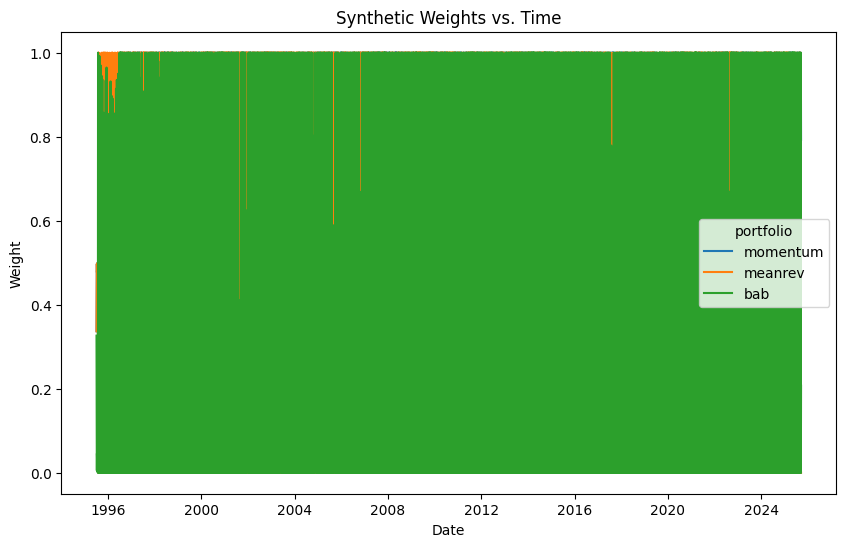

In [57]:
plt.figure(figsize=(10, 6))
sns.lineplot(portfolio_data, x='date', y='weight', hue='portfolio')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Synthetic Weights vs. Time')

In [ ]:
big_data = (
    big_data
    .with_columns(pl.col('momentum_weight').fill_null(0)
    )
    .with_columns(pl.col('meanrev_weight').fill_null(0)
    )
    .with_columns(pl.col('bab_weight').fill_null(0)
    )
)

date,barrid,return,fwd_return,predicted_beta,momentum_alpha,meanrev_alpha,bab_alpha,momentum_weight,meanrev_weight,bab_weight
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
1995-06-30,"""USAA191""",0.051471,-0.013986,0.823795,null,null,0.003645,0.0,0.0,-1.0844e-20
1995-06-30,"""USAA1W1""",0.057971,0.0,1.105022,null,null,-0.010093,0.0,0.0,-9.1201e-22
1995-06-30,"""USAA1Y1""",0.028777,-0.017483,1.636947,null,null,-0.027408,0.0,0.0,-4.8273e-21
1995-06-30,"""USAA2L1""",0.036585,0.002941,0.725292,null,null,0.010805,0.0,0.0,-4.2673e-21
1995-06-30,"""USAA311""",0.020134,-0.006579,0.798643,null,null,0.005402,0.0,0.0,-9.2198e-21
…,…,…,…,…,…,…,…,…,…,…
2025-09-15,"""USBQZR1""",-0.041651,null,1.365701,null,-0.159387,-0.024335,0.0,-1.3553e-20,-6.9890e-22
2025-09-15,"""USBRGT1""",0.0,null,1.264243,null,0.012975,-0.005506,0.0,-3.4045e-19,-3.7165e-21
2025-09-15,"""USBRH21""",0.011281,null,1.364664,null,-0.003457,-0.019368,0.0,-9.9263e-20,-2.6956e-21


In [19]:
# 1. Pivot meta-weights long → wide
meta_wide = (
    portfolio_data
    .pivot(values="weight", index="date", on="portfolio")
    .rename({"momentum": "momentum_mw", "meanrev": "meanrev_mw", "bab": "bab_mw"})
)

# 2. Join with asset-level table
combined = big_data.join(meta_wide, on="date", how="inner")

# 3. Compute portfolio weights
final_weights = combined.with_columns([
    (pl.col("momentum_weight") * pl.col("momentum_mw") +
     pl.col("meanrev_weight")  * pl.col("meanrev_mw")  +
     pl.col("bab_weight")      * pl.col("bab_mw")
    ).alias("total_weight")
])

final_weights


date,barrid,return,fwd_return,predicted_beta,momentum_alpha,meanrev_alpha,bab_alpha,momentum_weight,meanrev_weight,bab_weight,momentum_mw,meanrev_mw,bab_mw,total_weight
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1995-07-05,"""USAA191""",0.0,-0.007092,0.825965,null,null,0.003532,0.0,0.0,-8.7919e-21,0.435047,0.435047,0.129906,-1.1421e-21
1995-07-05,"""USAA1W1""",-0.061644,-0.007299,1.107636,null,null,-0.010226,0.0,0.0,-4.1150e-22,0.435047,0.435047,0.129906,-5.3457e-23
1995-07-05,"""USAA1Y1""",0.046263,0.0,1.631187,null,null,-0.026971,0.0,0.0,-4.7758e-21,0.435047,0.435047,0.129906,-6.2041e-22
1995-07-05,"""USAA2L1""",0.008798,-0.052326,0.657783,null,null,0.013757,0.0,0.0,-3.4944e-21,0.435047,0.435047,0.129906,-4.5394e-22
1995-07-05,"""USAA311""",0.019868,0.051948,0.795065,null,null,0.005505,0.0,0.0,-7.0238e-21,0.435047,0.435047,0.129906,-9.1244e-22
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-09-15,"""USBQZR1""",-0.041651,null,1.365701,null,-0.159387,-0.024335,0.0,-1.3553e-20,-6.9890e-22,0.792856,-3.3686e-23,0.207144,-1.4477e-22
2025-09-15,"""USBRGT1""",0.0,null,1.264243,null,0.012975,-0.005506,0.0,-3.4045e-19,-3.7165e-21,0.792856,-3.3686e-23,0.207144,-7.6985e-22
2025-09-15,"""USBRH21""",0.011281,null,1.364664,null,-0.003457,-0.019368,0.0,-9.9263e-20,-2.6956e-21,0.792856,-3.3686e-23,0.207144,-5.5837e-22


In [20]:
print(final_weights.group_by('date').agg(pl.col('total_weight').sum()))
print(final_weights['total_weight'].sum())
print(final_weights.select('date').unique().to_numpy().shape)

shape: (7_600, 2)
┌────────────┬──────────────┐
│ date       ┆ total_weight │
│ ---        ┆ ---          │
│ date       ┆ f64          │
╞════════════╪══════════════╡
│ 2009-11-05 ┆ 1.0          │
│ 2003-01-09 ┆ 1.0          │
│ 2001-12-12 ┆ 1.0          │
│ 2022-01-18 ┆ 1.0          │
│ 2021-04-28 ┆ 1.0          │
│ …          ┆ …            │
│ 2016-08-26 ┆ 1.0          │
│ 2002-04-19 ┆ 1.0          │
│ 2010-03-10 ┆ 1.0          │
│ 2014-11-07 ┆ 1.0          │
│ 2009-10-30 ┆ 1.0          │
└────────────┴──────────────┘
7488.242362781969
(7600, 1)


In [21]:
print(final_weights.group_by('date').agg(pl.col('barrid').n_unique()))

shape: (7_600, 2)
┌────────────┬────────┐
│ date       ┆ barrid │
│ ---        ┆ ---    │
│ date       ┆ u32    │
╞════════════╪════════╡
│ 2007-05-03 ┆ 2805   │
│ 2005-11-22 ┆ 2878   │
│ 2004-10-28 ┆ 2847   │
│ 2015-03-24 ┆ 2814   │
│ 2006-12-20 ┆ 2832   │
│ …          ┆ …      │
│ 2011-08-19 ┆ 2584   │
│ 2004-02-03 ┆ 2833   │
│ 2005-03-02 ┆ 2824   │
│ 2025-08-14 ┆ 2692   │
│ 2000-07-03 ┆ 2925   │
└────────────┴────────┘


In [ ]:
start = final_weights["date"].min()
end = final_weights["date"].max()

columns = ["date", "barrid", "fwd_return"]

returns = sfd.load_assets(start=start, end=end, in_universe=True, columns=columns)

benchmark = sfd.load_benchmark(start=start, end=end)

synMVO_ret = (
    returns.join(final_weights, on=["date", "barrid"], how="left")
    .join(benchmark, on=["date", "barrid"], how="left", suffix="_bmk")
    .with_columns(pl.col("fwd_return").truediv(100))
    .with_columns(pl.col("weight").sub("weight_bmk").alias("weight_act"))
    .with_columns(pl.col('weight', 'weight_act', 'weight_bmk').fill_null(0))
    .rename({"weight": "total", "weight_bmk": "benchmark", "weight_act": "active"})
    .unpivot(
        index=["date", "barrid", "fwd_return"],
        variable_name="portfolio",
        value_name="weight",
    )
    .group_by("date", "portfolio")
    .agg(pl.col("fwd_return").mul("weight").sum().alias("return"))
    .sort("date", "portfolio")
)

synMVO_ret

date,portfolio,return
date,str,f64
1995-07-05,"""active""",-0.009485
1995-07-05,"""benchmark""",0.011535
1995-07-05,"""total""",0.002047
1995-07-06,"""active""",-0.005824
1995-07-06,"""benchmark""",0.006099
…,…,…
2025-09-12,"""benchmark""",0.004897
2025-09-12,"""total""",0.007418
2025-09-15,"""active""",0.0


In [ ]:
synMVO_ret.group_by('portfolio', 'date').agg(pl.col('weight').sum()).filter(pl.col('portfolio').eq('benchmark')).sort('weight')

portfolio,date,weight
str,date,f64
"""benchmark""",2023-06-20,1.0
"""benchmark""",2023-02-08,1.0
"""benchmark""",2020-06-10,1.0
"""benchmark""",2022-11-04,1.0
"""benchmark""",2022-08-24,1.0
…,…,…
"""benchmark""",2016-02-11,1.0
"""benchmark""",2023-03-06,1.0
"""benchmark""",2023-08-01,1.0


In [ ]:
synMVO_ret = synMVO_ret.with_columns(pl.col('return').add(1).cum_prod().log1p().over('portfolio').alias('cumulative_return'))

Text(0, 0.5, 'Cumulative Log Return (%)')

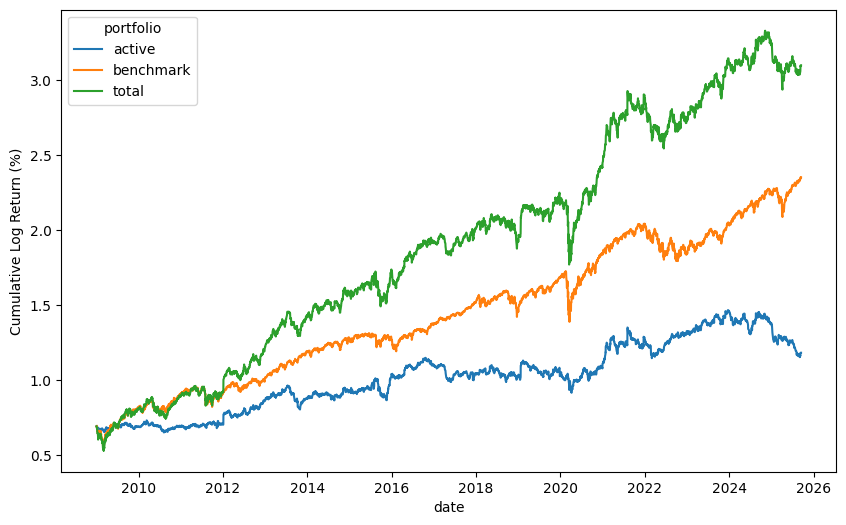

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(synMVO_ret, x='date', y='cumulative_return', hue='portfolio')
plt.ylabel('Cumulative Log Return (%)')

In [ ]:
sfp.generate_summary_table(synMVO_ret)

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",4201,6.37,17.26,126.57,0.37
"""Benchmark""",4201,15.26,18.62,852.5,0.82
"""Total""",4201,21.46,25.08,2020.94,0.86
